In [1]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.optimizers import SGD, Adam
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import applications
from keras import backend as k
import keras
import numpy as np
from sklearn.utils import shuffle
from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.



# Exercise 1: Transfer Learning with VGG16
---
Loading pre-trained weights

In [0]:
def vgg16_top():
  # This will load the whole VGG16 network, including the top Dense layers.
  # Note: inlcude the top Dense layer, input tensor shape is forced to be (224, 224, 3)
  vgg_model_top = applications.VGG16(weights='imagenet', include_top=True)
  vgg_model_top.summary()
  return vgg_model_top


In [3]:
vgg16_top()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

In [0]:
def vgg16_conv():
  # Not loaded the last two fully connected layers which act as the classifier. 
  # We are just loading the convolutional layers. Note: not specifying the shape of top layers, 
  # the input tensor shape is (None, None, 3),so you can use them for any size of images.
  # Specify input tensor,
  input_tensor = Input(shape=(32, 32, 3))
  vgg_model_conv = applications.VGG16(weights='imagenet',
                                      include_top=False,
                                      input_tensor=input_tensor)

 
  return vgg_model_conv


In [5]:
net = vgg16_conv()
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

---
Create a new network with bottom layers taken from VGG

In [0]:
def create_custom_model(net):

  # Creating dictionary that maps layer names to the layers
  layer_dict = dict([(layer.name, layer) for layer in net.layers])

  # Getting output tensor of the last VGG layer that we want to include
  x = layer_dict['block4_pool'].output

  
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(10, activation='softmax')(x)

  custom_model = Model(net.input,x)

  # Froze layers
  for layer in custom_model.layers[:14]:
    layer.trainable = False

  # Compile it
  custom_model.compile(loss='binary_crossentropy',
                       optimizer='rmsprop',
                       metrics=['accuracy'])

  return custom_model

---
Train network and get train history

In [0]:
def show_result(acc, val_acc, loss, val_loss):
    plt.rcParams['axes.facecolor']='white'
    f, axarr = plt.subplots(1 , 2)
    f.set_figwidth(10)

    # Accuracy
    axarr[0].plot(acc)
    axarr[0].plot(val_acc)
    axarr[0].set_title('model accuracy')
    axarr[0].set_ylabel('accuracy')
    axarr[0].set_xlabel('epoch')
    axarr[0].legend(['train', 'valid'], loc='upper left')

    # Loss
    axarr[1].plot(loss)
    axarr[1].plot(val_loss)
    axarr[1].set_title('model loss')
    axarr[1].set_ylabel('loss')
    axarr[1].set_xlabel('epoch')
    axarr[1].legend(['train', 'valid'], loc='upper left')
    
    plt.show()

In [0]:
def Train(net, x_train, y_train_h, x_test, y_test_h, batch_size, epochs,data_augmentation = False): 

    print('Start the training')
    file_name = 'best_model.h5'
    checkpointer = ModelCheckpoint(file_name, monitor='val_acc', save_best_only=True)
    early_stop = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, 
                               mode = 'max', patience = 5)
    
    if data_augmentation :
      print("-------------Using Data augmentation------------")
      # This will do realtime data augmentation:
      datagen = ImageDataGenerator(
          fill_mode = "nearest",
          zoom_range = 0.1,
          rotation_range=30,                    
          width_shift_range=0.1,               
          height_shift_range=0.1,              
          horizontal_flip=True,                
          vertical_flip=True)                 

      datagen.fit(x_train)
      history = net.fit_generator(datagen.flow(x_train, y_train_h, batch_size=batch_size),
                          steps_per_epoch=x_train.shape[0]//batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=[x_test,y_test_h],
                          callbacks=[early_stop,checkpointer])

    else :
      print("-----Not Using Data augmentation---------------")
      history = net.fit(x_train, y_train_h,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = [x_test,y_test_h],
                    callbacks=[early_stop,checkpointer])

      
    show_result(history.history['acc'], 
                history.history['val_acc'],
                history.history['loss'],
                history.history['val_loss'])

    del net
    net = load_model(file_name)
    
    loss_ts = net.evaluate(x_test, y_test_h, verbose=1)
   
    print("[Test loss: %f , Test acc.:%.2f%%]" %(loss_ts[0] , 100 * loss_ts[1])) 
    

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
___________________________

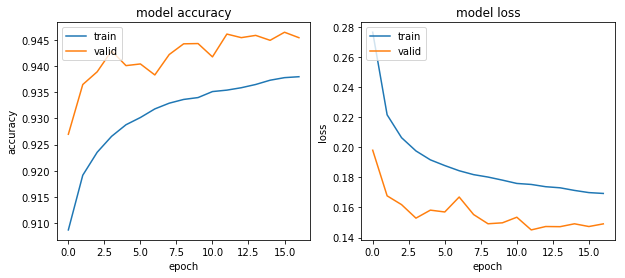

10000/10000 [==============================] - 5s 468us/step
[Test loss: 0.147356 , Test acc.:94.64%]


In [9]:
if __name__=='__main__':
  
  #Loading the data set
  (x_train , y_train) , (x_test , y_test) = cifar10.load_data()
  
  #Normalizing the set
  x_train = x_train.astype('float32')/255.
  x_test = x_test.astype('float32')/255.
  
  
  #Performing hot encoding
  y_train_h = keras.utils.to_categorical(y_train , 10)
  y_test_h = keras.utils.to_categorical(y_test , 10)
  
  
  # Change here
  #lr = 10**(np.random.uniform(-5,5))
  lr = 1e-3
  batch_size = 128
  epochs = 30
  adam = Adam(lr = lr)
  
  # Define VGG16 with pretained weights
  net = vgg16_conv()
  
  # create custom model 
  custom_model = create_custom_model(net)
  custom_model.summary()
  
  # tarin network
  Train(custom_model, x_train, y_train_h, x_test, y_test_h, batch_size, epochs)


---
Observe the network performance for different configurations:
1. Use pre-trained bottom layers of VGG up to layer name  (VGG_LN)
2. Data Augmentation (DA)
4. Earley stop patience (ESP)


Experiments | VGG_LN | DA | ESP | 
--- |---
Default |  **'block4_pool'**  |  **False**   |  **5**   |
Conf_1 |                -              |            -              |          -            |        
Conf_2 |                -              |            -              |          -            |        
Conf_3 |                -              |            -              |          -            |         
